In [1]:
import relative_imports

In [2]:
import sys
sys.path.insert(1, "/HOME1/users/students/shvl/projects/spatiotemporal")

%matplotlib widget

from spatiotemporal.SEN12MSCRTS import DatasetManager
from torch_datasets.minimal_dataset import S2Dataset
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interactive
import ipywidgets as widgets
from os.path import join
import xarray as xr
xr.set_options(display_expand_data=False)
from collections import defaultdict

In [3]:
root_dir='/LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRTS'
cloud_maps_dir="/LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRTS_cloud_maps"
cloud_histograms_csv = join(cloud_maps_dir, "cloud_histograms.csv")

In [4]:
dataset_manager = DatasetManager(
    root_dir=root_dir,
    cloud_maps_dir=cloud_maps_dir
)

In [5]:
dataset_manager_path = join(dataset_manager.project_directory, "config", "dataset_manager.csv")

# dataset_manager.load_dataset()
# dataset_manager.save_to_file(dataset_manager_path)
dataset_manager.load_from_file(dataset_manager_path)

# Visualize threshold effect for Sentinel-2

In [6]:
S2_histograms = xr.load_dataset(
    join(dataset_manager.project_directory, "stats", "S2_train_dataset_histogram.nc")
)
S2_histograms = S2_histograms["Sentinel-2 histogram"]

S2_histograms

<xarray.DataArray 'Sentinel-2 histogram' (Bin: 20, Band: 13, Reflectance: 10000)>
113091864 18292 2787 678 244 3 63 0 0 ... 321 221 258 273 311 263 283 313 216530
Coordinates:
  * Reflectance            (Reflectance) int32 0 1 2 3 4 ... 9996 9997 9998 9999
    Cloud_probability_bin  (Bin) int32 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
    Left_bin_edge          (Bin) float64 0.0 0.05 0.1 0.15 ... 0.8 0.85 0.9 0.95
    Right_bin_edge         (Bin) float64 0.05 0.1 0.15 0.2 ... 0.85 0.9 0.95 1.0
    Band_name              (Band) object 'Coastal aerosol' ... 'SWIR 2200nm'
    Band_resolution        (Band) object '60m' '10m' '10m' ... '60m' '20m' '20m'
  * Band                   (Band) object '1' '2' '3' '4' ... '9' '10' '11' '12'
Dimensions without coordinates: Bin
Attributes:
    subset:   train

In [7]:
default_threshold = 0.15
default_band = "3"

cmaps = {
    "10m": "inferno",
    "20m": "viridis",
    "60m": "cividis"
}

colors = {
    'Blue': 'blue',
    'Green': 'green',
    'Red': 'red',
    'NIR': 'yellow'
}
mpl_color_cycle = iter(plt.rcParams['axes.prop_cycle'])
colors = defaultdict(lambda: next(mpl_color_cycle)["color"], colors)

In [8]:
# create figure and axes

with plt.ioff():
    fig_1 = plt.figure(constrained_layout=True, figsize=(15, 7))
    grid_1 = fig_1.add_gridspec(ncols=3, nrows=3, width_ratios=[20, 1, 30])
    
    ax_histogram_full = fig_1.add_subplot(grid_1[:, 0])
    ax_cbar = fig_1.add_subplot(grid_1[:, 1])
    ax_histograms = {
        "10m": fig_1.add_subplot(grid_1[0, 2]),
        "20m": fig_1.add_subplot(grid_1[1, 2]),
        "60m": fig_1.add_subplot(grid_1[2, 2]),
    }

In [9]:
# add labels etc

fig_1.suptitle("Sentinel-2 reflectance histograms", fontsize=18)
ax_histogram_full.set_xlabel("Reflectance value")
ax_histogram_full.set_ylabel("Cloud probability [%]")
ax_cbar.yaxis.set_ticks_position("left")
ax_cbar.yaxis.set_label_position("left")
for resolution, ax_histogram in ax_histograms.items():
    ax_histogram.set_title(f"{resolution} bands")

In [10]:
# plot large histogram

histogram_image_full = ax_histogram_full.imshow(
    S2_histograms.sel(Band=default_band),
    aspect="auto",
    extent=(0, 10000, 1, 0),
    cmap=cmaps[S2_histograms.sel(Band=default_band).Band_resolution.item()],
    norm=mpl.colors.LogNorm(vmin=1, vmax=S2_histograms.sel(Band=default_band).quantile(0.99))
)

ax_histogram_full.set_title(f"Band {S2_histograms.sel(Band=default_band).Band.item()}"
                            f" - {S2_histograms.sel(Band=default_band).Band_name.item()}")

cbar_1 = fig_1.colorbar(
    histogram_image_full,
    cax=ax_cbar,
    ax=ax_histogram_full,
    label="Number of pixels"
)

In [11]:
# plot threshold

threshold_line = ax_histogram_full.hlines(
    y=default_threshold, 
    xmin=0, 
    xmax=10000,
    linewidth=1,
    color='r'
)
threshold_unselect = mpl.patches.Rectangle(
    xy=(0, default_threshold), 
    width=10000, 
    height=1.0-default_threshold,
    alpha=0.5, 
    linewidth=None, 
    facecolor='darkgrey'
)
ax_histogram_full.add_patch(threshold_unselect)

In [12]:
# plot small histograms

histogram_stairplots = {}

S2_histograms_norm = S2_histograms.where(S2_histograms.Right_bin_edge <= default_threshold, drop=True)
S2_histograms_norm = S2_histograms_norm.sum(dim="Bin")
S2_histograms_norm = S2_histograms_norm.clip(max=S2_histograms_norm.quantile(0.995, dim="Reflectance"))
S2_histograms_norm = S2_histograms_norm / S2_histograms_norm.sum(dim="Reflectance")

for band in S2_histograms_norm.Band:
    
    band_histogram = S2_histograms_norm.sel(Band=band)
    band_resolution = band_histogram.Band_resolution.item()
    band_name = band_histogram.Band_name.item()
    
    band_stairplot = ax_histograms[band_resolution].stairs(
        values=band_histogram,
        edges=np.arange(band_histogram.size + 1),
        alpha=0.3,
        color=colors[band_name],
        edgecolor=colors[band_name],
        fill=True,
        linewidth=0.5,
        label=f"Band {band.item()} - {band_name}"
    )
    histogram_stairplots[band.item()] = band_stairplot

for resolution, ax_histogram in ax_histograms.items():
    ax_histogram.legend(fontsize="small", loc='upper right', title="Bands")

In [13]:
# update graph interactively

slider_threshold = widgets.SelectionSlider(
    options=[(f"{threshold:.2f}", threshold) for threshold in S2_histograms.Right_bin_edge[:-1].values],
    description='Threshold cloud probability: ',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    style= {'description_width': 'initial'},
    layout=widgets.Layout(width="50%")
)

slider_band = widgets.SelectionSlider(
    options=[(f"Band {band.item()}", band.item()) for band in S2_histograms.Band],
    value=default_band,
    description='Band: ',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    style= {'description_width': 'initial'},
    layout=widgets.Layout(width="50%")
)

def update_fig_1(new_threshold, new_band):

    # update large histogram
    histogram_image_full.set_data(S2_histograms.sel(Band=new_band))
    histogram_image_full.set_cmap(cmaps[S2_histograms.sel(Band=new_band).Band_resolution.item()])
    histogram_image_full.set(norm=mpl.colors.LogNorm(vmin=1, vmax=S2_histograms.sel(Band=new_band).quantile(0.99)))
    ax_histogram_full.set_title(f"Band {S2_histograms.sel(Band=new_band).Band.item()} - {S2_histograms.sel(Band=new_band).Band_name.item()}")
    
    # update threshold
    threshold_line_coords = threshold_line.get_segments()[0]
    threshold_line_coords[:, 1] = new_threshold
    threshold_line.set_segments([threshold_line_coords])
    threshold_unselect.set(xy=(0, new_threshold), height=1.0-new_threshold)

    # update small histograms
    S2_histograms_norm = S2_histograms.where(S2_histograms.Right_bin_edge <= new_threshold, drop=True)
    S2_histograms_norm = S2_histograms_norm.sum(dim="Bin")
    S2_histograms_norm = S2_histograms_norm.clip(max=S2_histograms_norm.quantile(0.995, dim="Reflectance"))
    S2_histograms_norm = S2_histograms_norm / S2_histograms_norm.sum(dim="Reflectance")
    for band in S2_histograms_norm.Band:
        band_histogram = S2_histograms_norm.sel(Band=band)
        band_resolution = band_histogram.Band_resolution.item()
        band_name = band_histogram.Band_name.item()
        histogram_stairplots[band.item()].set_data(values=band_histogram)
    
    fig_1.canvas.draw_idle()

sliders_widget = interactive(update_fig_1, new_threshold=slider_threshold, new_band=slider_band)

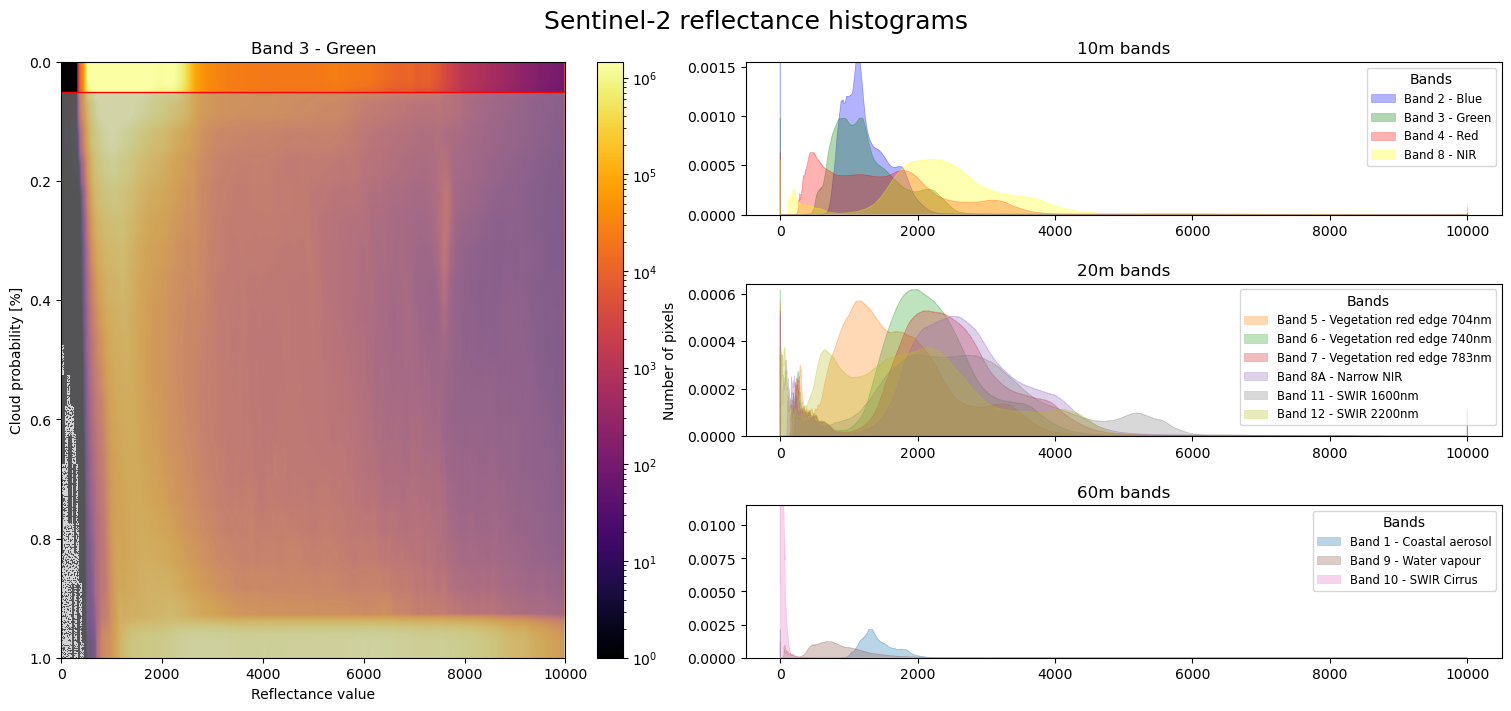

In [14]:
# display(sliders_widget, fig_1.canvas)
display(fig_1)

In [15]:
plt.close(fig_1)

# Investigate zeros

In [16]:
S2_histograms_thresholded = S2_histograms.where(S2_histograms.Right_bin_edge <= default_threshold, drop=True)
S2_histograms_thresholded = S2_histograms_thresholded.sum(dim="Bin")

In [17]:
S2_histograms_norm = S2_histograms_thresholded / S2_histograms_thresholded.sum(dim="Reflectance")

In [18]:
with plt.ioff():
    fig_2, ax_2 = plt.subplots(figsize=(9, 4), constrained_layout=True)

In [19]:
bar_width = 0.3
fig_2.suptitle("Number of low-valued pixels in dataset", fontsize=18)
ax_2.bar(
    x=np.arange(len(S2_histograms_norm.Band)) - bar_width,
    height=S2_histograms_norm[:, 0],  # plot number of pixels with value 0
    width=bar_width,
    label="Value = 0"
)
ax_2.bar(
    x=np.arange(len(S2_histograms_norm.Band)),
    height=S2_histograms_norm[:, 1],  # plot number of pixels with value 1
    width=bar_width,
    label="Value = 1"
)
ax_2.bar(
    x=np.arange(len(S2_histograms_norm.Band)) + bar_width,
    height=S2_histograms_norm[:, 2],  # plot number of pixels with value 2
    width=bar_width,
    label="Value = 2"
)
ax_2.set_xticks(
    ticks=np.arange(len(S2_histograms_norm.Band)),
    labels=S2_histograms_norm.Band.values
)
ax_2.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0, decimals=1))
ax_2.set_ylabel("Total percentage of pixels")
ax_2.set_xlabel("Band")
ax_2.legend(title="Reflectance")

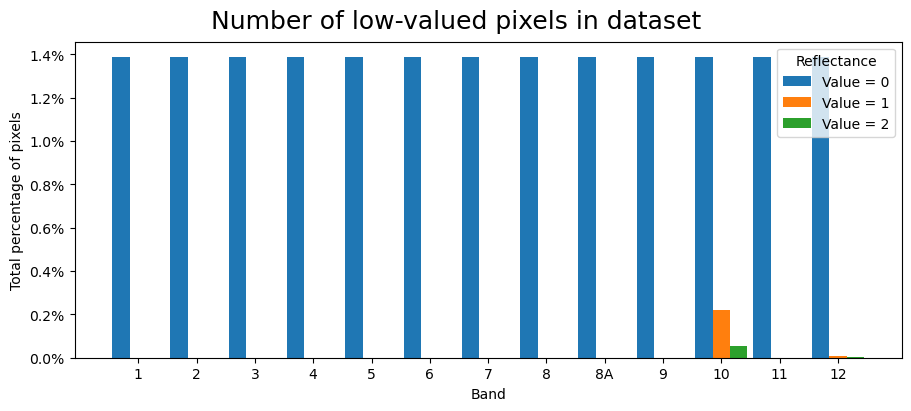

In [20]:
display(fig_2)

In [21]:
plt.close(fig_2)

## Cut off zero values

Clearly something is shady with zero-values pixels, so we remove them from the histogram

In [22]:
S2_histograms_thresholded[:, 0] = 0
S2_histograms_thresholded[:, 0]

<xarray.DataArray 'Sentinel-2 histogram' (Band: 13)>
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Coordinates:
    Reflectance      int32 0
    Band_name        (Band) object 'Coastal aerosol' 'Blue' ... 'SWIR 2200nm'
    Band_resolution  (Band) object '60m' '10m' '10m' '10m' ... '60m' '20m' '20m'
  * Band             (Band) object '1' '2' '3' '4' '5' ... '9' '10' '11' '12'

In [23]:
S2_histograms_norm = S2_histograms_thresholded / S2_histograms_thresholded.sum(dim="Reflectance")

S2_histograms_norm

<xarray.DataArray 'Sentinel-2 histogram' (Band: 13, Reflectance: 10000)>
0.0 2.49e-06 4.302e-07 1.164e-07 ... 8.348e-09 8.472e-09 5.482e-09 1.048e-05
Coordinates:
  * Reflectance      (Reflectance) int32 0 1 2 3 4 ... 9995 9996 9997 9998 9999
    Band_name        (Band) object 'Coastal aerosol' 'Blue' ... 'SWIR 2200nm'
    Band_resolution  (Band) object '60m' '10m' '10m' '10m' ... '60m' '20m' '20m'
  * Band             (Band) object '1' '2' '3' '4' '5' ... '9' '10' '11' '12'

In [24]:
S2_histograms_norm.sum(dim="Reflectance").values

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# Select parameters for rescaling

In [25]:
default_quantile_max = 0.96
default_quantile_min = 0.001
default_margin_min = 0.09
default_margin_max = 0.2

In [26]:
S2_histograms_cummulative = S2_histograms_norm.cumsum(dim="Reflectance")
S2_histograms_cummulative

<xarray.DataArray 'Sentinel-2 histogram' (Band: 13, Reflectance: 10000)>
0.0 2.49e-06 2.921e-06 3.037e-06 3.075e-06 3.077e-06 ... 1.0 1.0 1.0 1.0 1.0 1.0
Coordinates:
  * Reflectance      (Reflectance) int32 0 1 2 3 4 ... 9995 9996 9997 9998 9999
    Band_name        (Band) object 'Coastal aerosol' 'Blue' ... 'SWIR 2200nm'
    Band_resolution  (Band) object '60m' '10m' '10m' '10m' ... '60m' '20m' '20m'
  * Band             (Band) object '1' '2' '3' '4' '5' ... '9' '10' '11' '12'

In [27]:
max_quantile_values = np.apply_along_axis(
    func1d=np.searchsorted,
    axis=1,
    arr=S2_histograms_cummulative,
    v=default_quantile_max
)
max_quantile_values = max_quantile_values[:, np.newaxis]

max_quantile_values.shape

(13, 1)

In [28]:
min_quantile_values = np.apply_along_axis(
    func1d=np.searchsorted,
    axis=1,
    arr=S2_histograms_cummulative,
    v=default_quantile_min
)
min_quantile_values = min_quantile_values[:, np.newaxis]

min_quantile_values.shape

(13, 1)

In [29]:
d_quantile_values = max_quantile_values - min_quantile_values
d_quantile_values.shape

(13, 1)

In [30]:
rescaled_coordinates = (np.append(S2_histograms_norm.Reflectance.values, 10000)[np.newaxis, :] - min_quantile_values) / d_quantile_values
rescaled_coordinates.shape

(13, 10001)

### Plot histograms for rescaling

In [31]:
S2_histograms

<xarray.DataArray 'Sentinel-2 histogram' (Bin: 20, Band: 13, Reflectance: 10000)>
113091864 18292 2787 678 244 3 63 0 0 ... 321 221 258 273 311 263 283 313 216530
Coordinates:
  * Reflectance            (Reflectance) int32 0 1 2 3 4 ... 9996 9997 9998 9999
    Cloud_probability_bin  (Bin) int32 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
    Left_bin_edge          (Bin) float64 0.0 0.05 0.1 0.15 ... 0.8 0.85 0.9 0.95
    Right_bin_edge         (Bin) float64 0.05 0.1 0.15 0.2 ... 0.85 0.9 0.95 1.0
    Band_name              (Band) object 'Coastal aerosol' ... 'SWIR 2200nm'
    Band_resolution        (Band) object '60m' '10m' '10m' ... '60m' '20m' '20m'
  * Band                   (Band) object '1' '2' '3' '4' ... '9' '10' '11' '12'
Dimensions without coordinates: Bin
Attributes:
    subset:   train

In [32]:
with plt.ioff():
    fig_3 = plt.figure(constrained_layout=True, figsize=(13, 7))
    grid_3 = fig_3.add_gridspec(ncols=2, nrows=3, width_ratios=[9, 4])

    ax_histograms_3 = {
        "10m": fig_3.add_subplot(grid_3[0, 0]),
        "20m": fig_3.add_subplot(grid_3[1, 0]),
        "60m": fig_3.add_subplot(grid_3[2, 0]),
    }
    ax_residuals_3 = {
        "10m": fig_3.add_subplot(grid_3[0, 1]),
        "20m": fig_3.add_subplot(grid_3[1, 1]),
        "60m": fig_3.add_subplot(grid_3[2, 1])
    }

In [33]:
ax_histograms_3["10m"].set_title("Band histograms after rescaling")
ax_residuals_3["10m"].set_title("Clipped residuals after rescaling")

Text(0.5, 1.0, 'Clipped residuals after rescaling')

In [34]:
histogram_stairplots_3 = {}
residual_bins_3 = {"low_residual": {}, "high_residual": {}}

for band_num, band in enumerate(S2_histograms_norm.Band):
    
    band_histogram = S2_histograms_norm.sel(Band=band)
    band_histogram = band_histogram.clip(max=band_histogram.quantile(0.9999))
    band_resolution = band_histogram.Band_resolution.item()
    band_name = band_histogram.Band_name.item()
    band = band.item()

    # draw histograms on the left
    histogram_stairplots_3[band] = ax_histograms_3[band_resolution].stairs(
        values=band_histogram * d_quantile_values[band_num],
        edges=rescaled_coordinates[band_num],
        alpha=0.3,
        color=colors[band_name],
        edgecolor=colors[band_name],
        fill=True,
        linewidth=0.5,
        label=f"Band {band} - {band_name}"
    )
    ax_histograms_3[band_resolution].set_xlim([-0.2, 1.5])

    # initialize residual plots
    # first without positions
    residual_bins_3["low_residual"][band] = ax_residuals_3[band_resolution].add_patch(
        mpl.patches.Rectangle(
            xy=(0, 0),
            height=0.01,
            width=0.4,
            color="silver"
        )
    )
    residual_bins_3["high_residual"][band] = ax_residuals_3[band_resolution].add_patch(
        mpl.patches.Rectangle(
            xy=(0, 0),
            height=0.02,
            width=0.4,
            color=colors[band_name]
        )
    )

min_margin_lines = []
max_margin_lines = []
for resolution, ax_histogram in ax_histograms_3.items():  
    min_margin_lines.append(ax_histogram.axvline(0.0, color="gray", linestyle="dotted", alpha=0.5))
    max_margin_lines.append(ax_histogram.axvline(1.0, color="gray", linestyle="dotted", alpha=0.5))
    ax_histogram.axvline(0.0, color="red", linestyle=(0, (4, 12)), alpha=0.8)
    ax_histogram.axvline(1.0, color="red", linestyle=(0, (4, 12)), alpha=0.8)
    ax_histogram.legend(fontsize="small", loc='upper right', title="Bands")  

In [35]:
# finish residual plots by adding correct positions and ticks
for resolution, ax in ax_residuals_3.items():
    bands = S2_histograms.Band.where(S2_histograms.Band_resolution==resolution, drop=True)
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0, decimals=1))
    ax.set_ylim(bottom=0, top=0.035)
    ax.set_xticks(ticks=range(len(bands)), labels=bands.values)
    ax.set_xlim(left=-1, right=len(bands))
    
    for band_num, band in enumerate(bands):
        band = band.item()
        residual_bins_3["low_residual"][band].set_x(band_num-0.4)
        residual_bins_3["high_residual"][band].set_x(band_num)

In [36]:
def update_image_3(min_quantile, max_quantile, max_margin, min_margin):
    
    min_quantile_values = np.apply_along_axis(
        func1d=np.searchsorted,
        axis=1,
        arr=S2_histograms_cummulative,
        v=min_quantile
    )[:, np.newaxis]
    max_quantile_values = np.apply_along_axis(
        func1d=np.searchsorted,
        axis=1,
        arr=S2_histograms_cummulative,
        v=max_quantile
    )[:, np.newaxis]
    d_quantile_values = max_quantile_values - min_quantile_values
    d_margin = 1 - max_margin - min_margin

    # Calculate new min-max values using margins
    min_values_new = min_quantile_values - d_quantile_values * (min_margin / d_margin)
    max_values_new = min_values_new + (d_quantile_values / d_margin)
    min_values_new = np.rint(min_values_new)
    max_values_new = np.rint(max_values_new)
    # d_new = d_quantile_values / d_margin
    # d_new = max_values_new - min_values_new
    low_residuals = S2_histograms_cummulative.sel(Reflectance=min_values_new.flatten(), method="nearest").values.diagonal()
    high_residuals = 1 - S2_histograms_cummulative.sel(Reflectance=max_values_new.flatten(), method="nearest").values.diagonal()
    
    # rescaled_coordinates_margin = (np.arange(band_histogram.size + 1)[np.newaxis, :] - min_values_new) / (d_new)
    rescaled_coordinates = (np.arange(band_histogram.size + 1)[np.newaxis, :] - min_quantile_values) / (d_quantile_values)
    rescaled_coordinates_margin = min_margin + rescaled_coordinates * (d_margin)
    
    _ = [min_margin_line.set(xdata=min_margin) for min_margin_line in min_margin_lines]
    _ = [max_margin_line.set(xdata=1-max_margin) for max_margin_line in max_margin_lines]

    
    for band_num, band in enumerate(S2_histograms_norm.Band):
        band = band.item()
        histogram_stairplots_3[band].set_data(edges=rescaled_coordinates_margin[band_num])
        residual_bins_3["high_residual"][band].set_height(high_residuals[band_num])
        residual_bins_3["low_residual"][band].set_height(low_residuals[band_num])

In [37]:
slider_min_quantile = widgets.FloatSlider(
    value=default_quantile_min,
    min=0.0,
    max=0.04,
    step=0.0001,
    description='Min:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.4f',
    style= {'description_width': 'initial'},
    layout=widgets.Layout(width="50%")
)
slider_max_quantile = widgets.FloatSlider(
    value=default_quantile_max,
    min=0.95,
    max=1.00,
    step=0.0001,
    description='Max:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.4f',
    style= {'description_width': 'initial'},
    layout=widgets.Layout(width="50%")
)
slider_max_margin = widgets.FloatSlider(
    value=default_margin_max,
    min=0.0,
    max=0.3,
    step=0.001,
    description='Max margin:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.4f',
    style= {'description_width': 'initial'},
    layout=widgets.Layout(width="50%")
)
slider_min_margin = widgets.FloatSlider(
    value=default_margin_min,
    min=0,
    max=0.3,
    step=0.001,
    description='Min margin:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.4f',
    style= {'description_width': 'initial'},
    layout=widgets.Layout(width="50%")
)
sliders_quantile_widget = interactive(
    update_image_3, 
    min_quantile=slider_min_quantile,
    max_quantile=slider_max_quantile,
    max_margin=slider_max_margin,
    min_margin=slider_min_margin
)

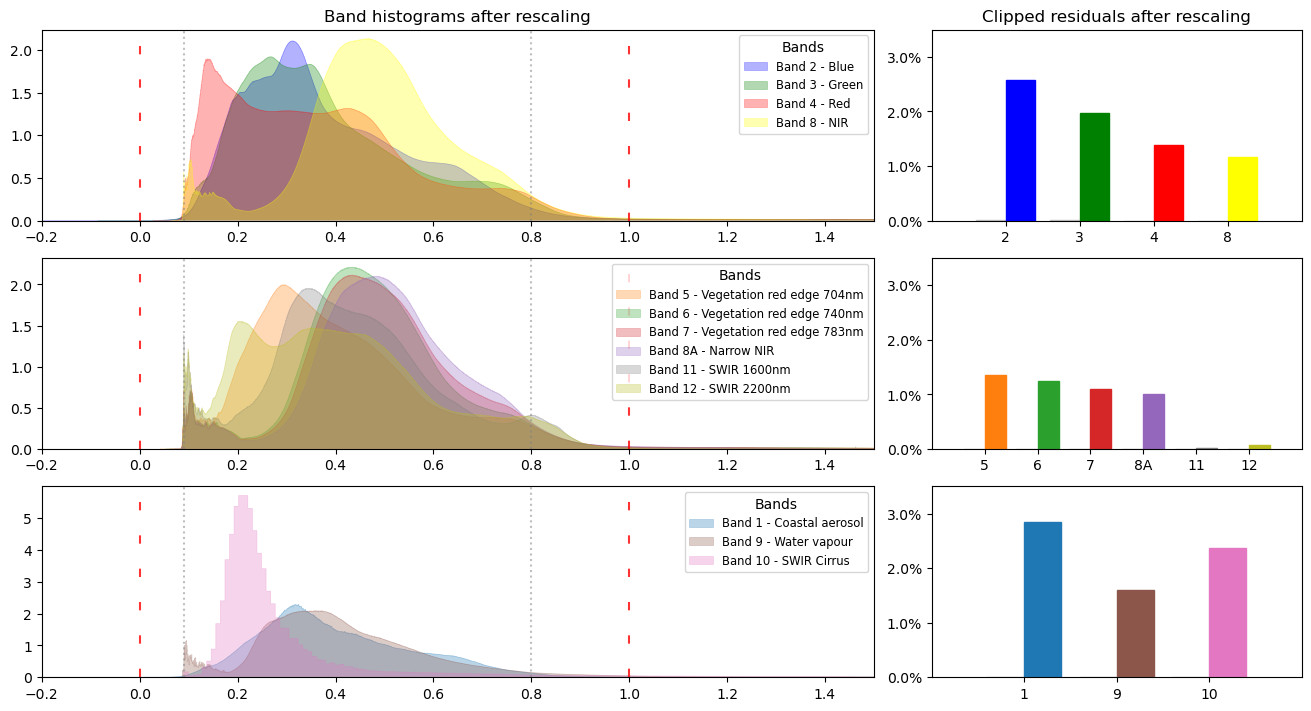

In [38]:
# display(fig_3.canvas, sliders_quantile_widget)
display(fig_3)

In [39]:
plt.close(fig_3)

# Process results

In [40]:
min_quantile = slider_min_quantile.value
max_quantile = slider_max_quantile.value
min_margin = slider_min_margin.value
max_margin = slider_max_margin.value

min_quantile, max_quantile, min_margin, max_margin

(0.001, 0.96, 0.09, 0.2)

In [41]:
d_margin = 1 - max_margin - min_margin

min_values_new = min_quantile_values - d_quantile_values * (min_margin / d_margin)
max_values_new = min_values_new + (d_quantile_values / d_margin)

### Min-Max values (without margin)

In [42]:
min_max_df_no_margin = pd.DataFrame(
    data=np.concatenate([min_quantile_values, max_quantile_values], axis=1),
    columns=["min", "max"],
    index=pd.Index(np.arange(13), name="band")    
)
min_max_df_no_margin

,min,max
band,,
0,972,2067
1,695,2082
2,477,2402
3,268,3332
4,223,3493
5,189,3784
6,164,4180
7,129,4035
8,116,4395


### Min-Max values with margin

In [43]:
min_max_df = pd.DataFrame(
    data=np.concatenate([min_values_new, max_values_new], axis=1),
    columns=["min", "max"],
    index=pd.Index(np.arange(13), name="band")    
)
min_max_df = min_max_df.round(0).astype(np.int64)

min_max_df

,min,max
band,,
0,833,2375
1,519,2473
2,233,2944
3,-120,4195
4,-192,4414
5,-267,4797
6,-345,5311
7,-366,5135
8,-426,5600


# Test rescaling

In [44]:
with plt.ioff():
    fig_4 = plt.figure(constrained_layout=True, figsize=(11, 7))
    grid_4 = fig_4.add_gridspec(ncols=1, nrows=3)

    ax_histograms_4 = {
        "10m": fig_4.add_subplot(grid_4[0, 0]),
        "20m": fig_4.add_subplot(grid_4[1, 0]),
        "60m": fig_4.add_subplot(grid_4[2, 0]),
    }
    for resolution, ax_histogram in ax_histograms_4.items():
        ax_histogram.set_title(f"{resolution} bands")

In [45]:
min_values_test = min_max_df["min"].values[..., np.newaxis]
max_values_test = min_max_df["max"].values[..., np.newaxis]
d_values_test = max_values_test - min_values_test

In [46]:
rescaled_coordinates_test = (np.arange(band_histogram.size + 1)[np.newaxis, :] - min_values_test) / (d_values_test)

In [47]:
histogram_stairplots_4 = {}
S2_histograms_thresholded_test = S2_histograms.where(S2_histograms.Right_bin_edge <= default_threshold, drop=True)
S2_histograms_thresholded_test = S2_histograms_thresholded_test.sum(dim="Bin")

for band_num, band in enumerate(S2_histograms_thresholded_test.Band):
    
    band_histogram = S2_histograms_thresholded_test.sel(Band=band)
    band_histogram = band_histogram.clip(max=band_histogram.quantile(0.9999))
    band_resolution = band_histogram.Band_resolution.item()
    band_name = band_histogram.Band_name.item()
    band = band.item()

    # draw histograms on the left
    histogram_stairplots_4[band] = ax_histograms_4[band_resolution].stairs(
        values=band_histogram * d_values_test[band_num],
        edges=rescaled_coordinates_test[band_num],
        alpha=0.3,
        color=colors[band_name],
        edgecolor=colors[band_name],
        fill=True,
        linewidth=0.5,
        label=f"Band {band} - {band_name}"
    )
    ax_histograms_4[band_resolution].set_xlim([-0.5, 1.5])

for _, ax_histogram in ax_histograms_4.items():
    ax_histogram.axvline(0.5, color="red", linestyle=(0, (4, 12)), alpha=0.8)

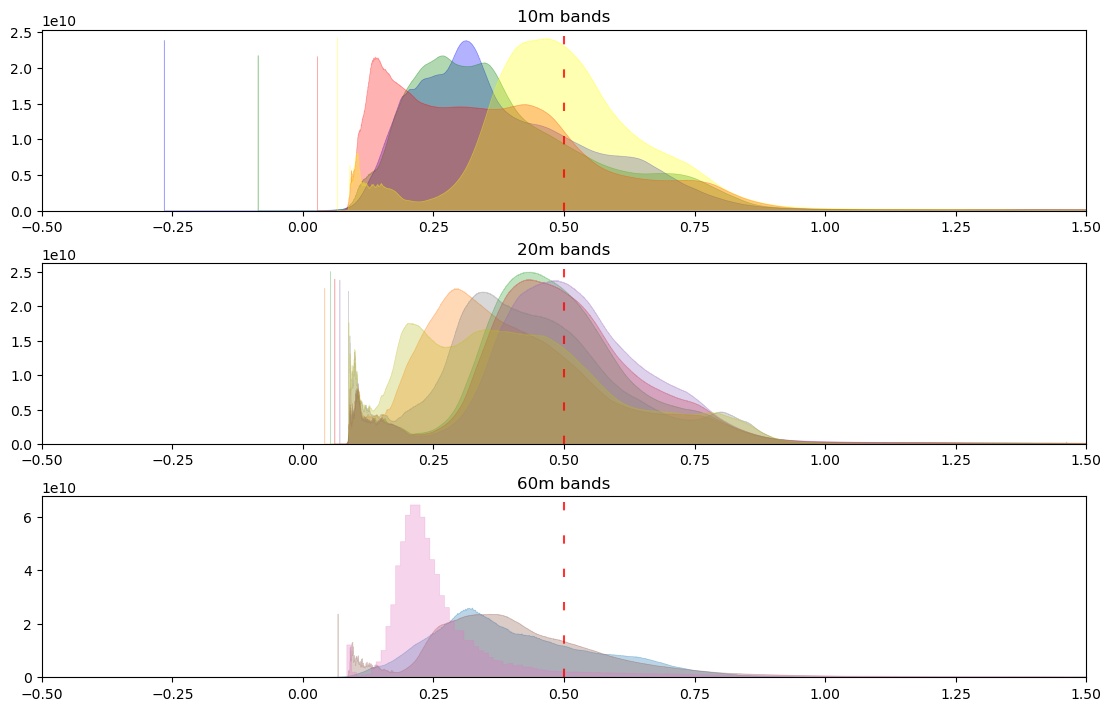

In [48]:
display(fig_4)

In [49]:
plt.close(fig_4)

# Save

In [50]:
min_max_df.to_csv(join(dataset_manager.project_directory, "stats", "S2_min_max.csv"))

In [51]:
min_max_df_saved = pd.read_csv(join(dataset_manager.project_directory, "stats", "S2_min_max.csv"), index_col="band")
min_max_df_saved

,min,max
band,,
0,833,2375
1,519,2473
2,233,2944
3,-120,4195
4,-192,4414
5,-267,4797
6,-345,5311
7,-366,5135
8,-426,5600


# Test dataset functions

In [52]:
utils = dataset_manager.utils

In [53]:
random_state = np.random.RandomState(42)

random_indices = [
    dataset_manager.data.index[i]
    for i in random_state.randint(low=0, high=len(dataset_manager.data), size=(16))
]

In [54]:
original_S2_images = [
    utils.read_tif(dataset_manager.data.loc[index, "S2"])
    for index in random_indices
]

original_S2_images[0].shape, original_S2_images[0].min(), original_S2_images[0].max()

((13, 256, 256), 135, 5521)

In [55]:
rescaled_S2_images = [
    utils.rescale_s2(image, clip=False)
    for image in original_S2_images
]

rescaled_S2_images[0].shape, rescaled_S2_images[0].min(), rescaled_S2_images[0].max()

((13, 256, 256), 0.1290748898678414, 1.21875)

In [56]:
with plt.ioff():
    fig_5, axs_5 = plt.subplots(nrows=4, ncols=4, figsize=(12, 12), tight_layout=True)

In [57]:
for ax, image, index in zip(axs_5.flatten(), rescaled_S2_images, random_indices):
    ax.imshow(
        np.clip(
            utils.bands_last(image[[3, 2, 1]]),
            a_min=0.0, 
            a_max=1.0
        )
    )
    ax.set_axis_off()
    ax.set_title(index)

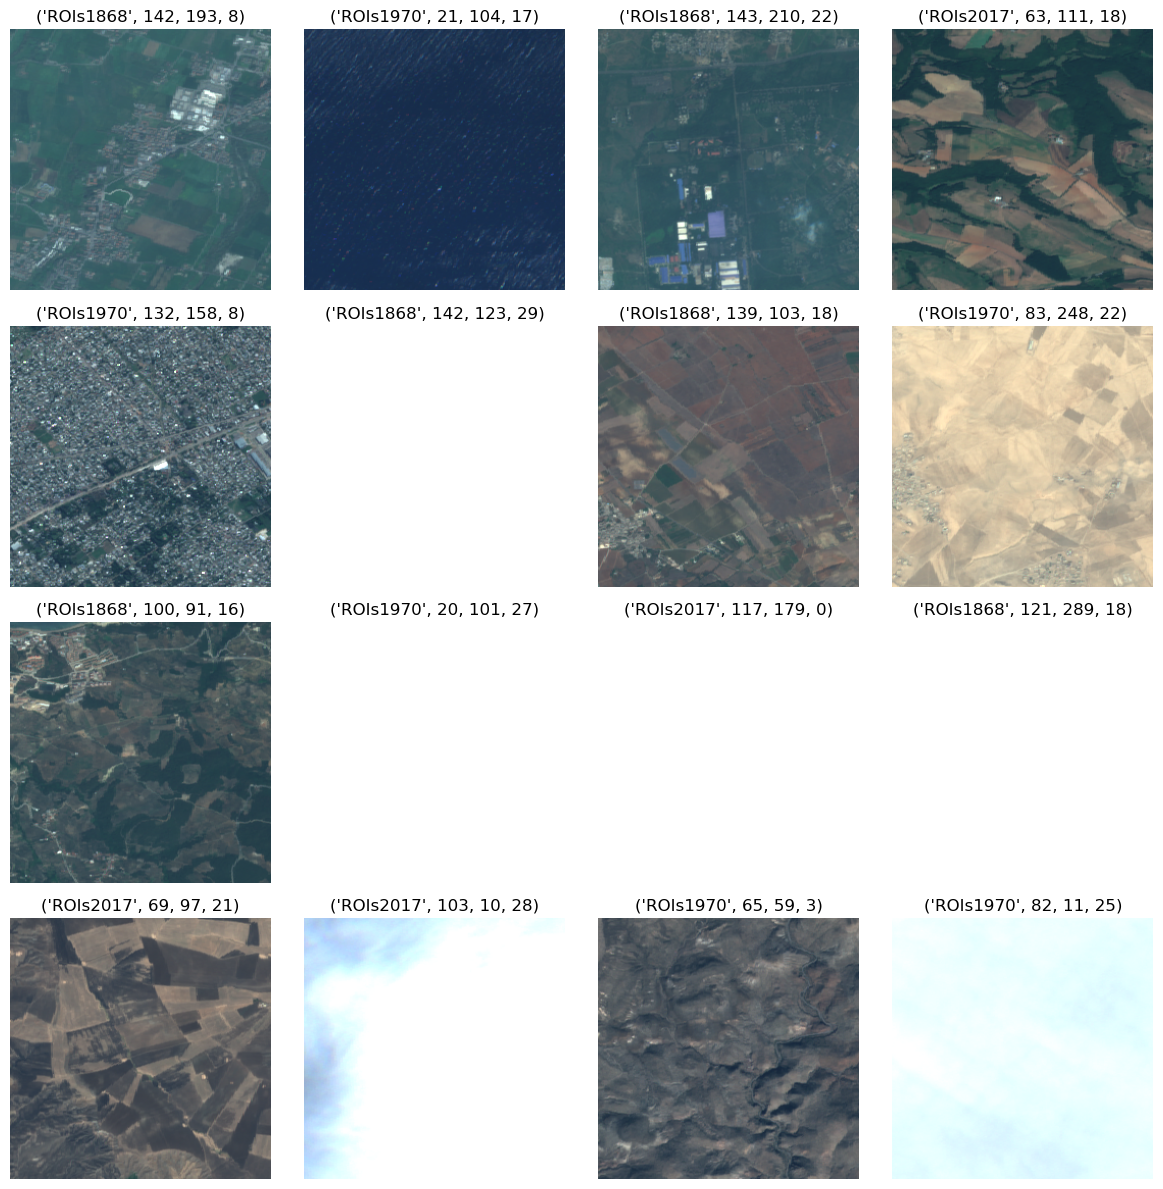

In [58]:
display(fig_5)

In [59]:
plt.close(fig_5)

### Test back-rescaling

In [60]:
back_rescaled_S2_images = [utils.rescale_s2_back(image) for image in rescaled_S2_images]

In [61]:
all([
    np.all(original_image == back_rescaled_image)
    for original_image, back_rescaled_image
    in zip(original_S2_images, back_rescaled_S2_images)
])

True